In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import kurtosis,skew
from neurokit2.signal import signal_rate
from neurokit2.signal import signal_timefrequency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay

import bokeh
from bokeh.io import output_notebook
output_notebook()

import scipy
from scipy.signal import spectrogram
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline

import neurokit2 as nk
import scipy.signal as signal
from importlib import reload

import utilities2 as ut
# import finalAnalytics as fa
import pathlib

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pickle

import os
import json
import datetime

reload(ut)

classes = {"walk": 0, "jump": 1, "spin": 2, "stamp": 3}
wfs = ['accel_X', 'accel_Y', 'accel_Z', 'gyro_X', 'gyro_Y', 'gyro_Z']
extra_wfs = ['int1_gyro_X', 'int1_gyro_Y','int1_gyro_Z']
super_extra_wfs = ['int1_gyro_X', 'int2_gyro_X', 'int1_gyro_Y', 'int2_gyro_Y','int1_gyro_Z','int2_gyro_Z']
artifact_rows = [39,56,26, 22, 11] #11 is questionable, ends early

Loading BokehJS ...

In [2]:
## Models

filename_rf = 'randomForestModel_ES.pickle'
filename_knn = 'knnModel_ES.pickle'
filename_s = 'scaler_ES.pickle'

# load model
loaded_rf = pickle.load(open(filename_rf, "rb"))
loaded_knn = pickle.load(open(filename_knn, "rb"))

# load scaler
loaded_s = pickle.load(open(filename_s, "rb"))

In [3]:
## Load file
path = '/Users/isabellagomez/Documents/Tesis/Classification_v2/artlab/choreo1.csv'
df = ut.cleanRead(path)

## Event segmentation
left_x, right_x = ut.tightBounds(df,mode='mult',fat_avg = 15, prom=.2, peakFinding='scipy', int_size=0.8, step_size=0.05)

# print(len(left_x))


In [5]:
def imuProcess_event(df, intervalTime = 1, stats = ['med_','std_','mean_'], mets = ['accel_X','accel_Y','accel_Z','gyro_X','gyro_Y', 'gyro_Z'], integrate = False, partial = 1):
    feature_names = []
    individualTrials = []
    GT = {'GT': []}
    for met in mets:
        for stat in stats:
            feature_names.append(stat+met)       
    
    #### File by file analysis ####
    for filepath, groundTruth in zip(df.path.values,df.GT.values):
        data = ut.cleanRead(filepath)
        time = data.Time.values
        try:
            reltime = time - time[0]
        except:
            print(filepath, time)
        data['Time'] = reltime
        try:
            pairs = ut.tightBounds(data,mode='mult',fat_avg = 15, prom=.2, peakFinding='scipy', int_size=intervalTime, step_size=0.05, separate_lr=False)
        except:
            print(filepath)
        for start, stop in pairs:
            stop = start + partial
            ds = {k: [] for k in feature_names}
            for met in mets:
                #FILTER
                thing = ut.filterBetween(data,met,start,stop)
                ds['med_' + met].append(np.median(thing))
                ds['std_'+ met].append(np.std(thing))
                ds['mean_'+ met].append(np.mean(thing))
            GT['GT'].append(groundTruth)
            subResult = pd.DataFrame(ds)
            individualTrials.append(subResult)
            
    result = pd.concat(individualTrials)
    result.reset_index(inplace=True, drop=True)
    return result, GT['GT']

In [10]:
## Event classification
files = pd.DataFrame()
files['path'] = [path]
GT = 1
files['GT'] = GT

X,y = ut.imuProcess_event(files, partial=0.5)
X_test = loaded_s.transform(X)
y_pred = loaded_rf.predict(X_test)

# print(type(y_pred))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- kurt_accel_X
- kurt_accel_Y
- kurt_accel_Z
- kurt_gyro_X
- kurt_gyro_Y
- ...


In [7]:
## Event timing df
events = pd.DataFrame({'time':left_x,'event':y_pred})

events

,time,event
0,15.40,1
1,23.58,4
2,26.68,4
3,28.14,4
4,30.26,4
5,35.64,1
6,39.04,1
7,41.12,4
8,43.01,4
9,47.30,1


Text(0.5, 0, 'Time [s]')

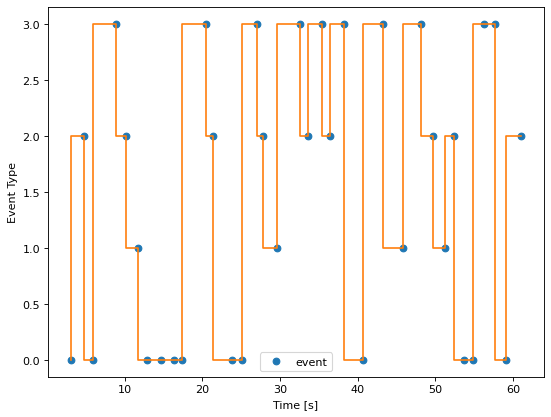

In [15]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(events['time'],events['event'],'o', label='event')
plt.step(events['time'],events['event'])
plt.legend()
plt.ylabel('Event Type')
plt.xlabel('Time [s]')

In [25]:
## source: https://github.com/ryendu/sound2ahap/blob/main/utils.py

class AHAP:
    def __init__(self):
        self.data = {
            "Version": 1.0,
            "Metadata": {
                "Project": "Basis",
                "Created": str(datetime.datetime.now()),
                "Description": "AHAP file generated based on a audio file by Basis app.",
                "Created By": "Ryan Du"
            },
            "Pattern": []
        }

    def add_event(self, etype, time, parameters, event_duration=None, event_waveform_path=None):
        """
        Adds an event to the pattern
        etype: type of event
            - possible values: AudioContinuous, AudioCustom, HapticTransient, and HapticContinuous
        time: time of event
            - in seconds
        parameters: event parameters
            - as a list of dictionaries
        """
        pattern = {
            "Event": {
                "Time": time,
                "EventType": etype,
                "EventParameters": parameters
            }
        }
        if event_duration != None:
            pattern["Event"]["EventDuration"] = event_duration
        if event_waveform_path != None:
            pattern["Event"]["EventWaveformPath"] = event_waveform_path
        self.data["Pattern"].append(pattern)

    def add_haptic_transient_event(self, time, haptic_intensity, haptic_sharpness=0.1):
        """
        Adds a haptic transient event to the pattern
        time: time of event - in seconds
        haptic_intensity: intensity of haptic
        haptic_sharpness: sharpness of haptic
        """
        parameters = [
            {
                "ParameterID": "HapticIntensity",
                "ParameterValue": haptic_intensity,
            },
            {
                "ParameterID": "HapticSharpness",
                "ParameterValue": haptic_sharpness,
            }
        ]

        self.add_event(etype="HapticTransient",
                       time=time, parameters=parameters)

    def add_haptic_continuous_event(self, time, event_duration=1, haptic_intensity=0.5, haptic_sharpness=0.5):
        """
        Adds a haptic continuous event to the pattern
        time: time of event - in seconds
        haptic_intensity: intensity of haptic
        haptic_sharpness: sharpness of haptic
        """
        parameters = [
            {
                "ParameterID": "HapticIntensity",
                "ParameterValue": haptic_intensity,
            },
            {
                "ParameterID": "HapticSharpness",
                "ParameterValue": haptic_sharpness,
            }
        ]

        self.add_event(etype="HapticContinuous", time=time,
                       parameters=parameters, event_duration=event_duration)

    def add_audio_custom_event(self, time, wav_filepath, volume=0.75):
        """
        Adds an audio custom event to the pattern
        time: time of event
            - in seconds
        wav_filepath: path to the wav file containing the sound
        volume: volume from 0 to 1
        """
        parameters = [
            {
                "ParameterID": "AudioVolume",
                "ParameterValue": volume,
            }
        ]
        self.add_event(etype="AudioCustom", time=time,
                       parameters=parameters, event_waveform_path=wav_filepath)

    def add_parameter_curve(self, parameter_id, start_time, control_points):
        """
        Adds a parameter curve to the pattern
        parameter_id: the parameter to dynamically change
            - possible values: HapticIntensityControl, HapticSharpnessControl, HapticAttackTimeControl, HapticDecayTimeControl, HapticReleaseTimeControl, AudioBrightnessControl, AudioPanControl, AudioPitchControl, AudioVolumeControl, AudioAttackTimeControl, AudioDecayTimeControl, AudioReleaseTimeControl
        start_time: time of the start of the curve
            - in seconds
        control_points: list of control points
            - as a list of dictionaries in the format: [{"Time":time,"ParameterValue":value}]
        """
        pattern = {
            "ParameterCurve": {
                "ParameterID": parameter_id,
                "Time": start_time,
                "ParameterCurveControlPoints": control_points
            }
        }

        self.data["Pattern"].append(pattern)

    def print_data(self):
        print(self.data)

    def export(self, filename, path):
        with open(os.path.join(path, filename), 'w') as f:
            f.write(json.dumps(self.data))


In [28]:
## Create AHAP file

ints = [0.4, 0.95, 0.6, 0.8]

ahap = AHAP()

for idx, event in events.iterrows():
    time = event['time']
    haptic_intensity = ints[int(event['event'])]
    
    ahap.add_haptic_transient_event(time, haptic_intensity)



In [29]:
## What does the ahap data look like?

ahap.data

{'Version': 1.0,
 'Metadata': {'Project': 'Basis',
  'Created': '2023-10-10 23:53:40.358393',
  'Description': 'AHAP file generated based on a audio file by Basis app.',
  'Created By': 'Ryan Du'},
 'Pattern': [{'Event': {'Time': 3.0,
    'EventType': 'HapticTransient',
    'EventParameters': [{'ParameterID': 'HapticIntensity',
      'ParameterValue': 0.4},
     {'ParameterID': 'HapticSharpness', 'ParameterValue': 0.1}]}},
  {'Event': {'Time': 4.78,
    'EventType': 'HapticTransient',
    'EventParameters': [{'ParameterID': 'HapticIntensity',
      'ParameterValue': 0.6},
     {'ParameterID': 'HapticSharpness', 'ParameterValue': 0.1}]}},
  {'Event': {'Time': 5.929999999999999,
    'EventType': 'HapticTransient',
    'EventParameters': [{'ParameterID': 'HapticIntensity',
      'ParameterValue': 0.4},
     {'ParameterID': 'HapticSharpness', 'ParameterValue': 0.1}]}},
  {'Event': {'Time': 8.870000000000012,
    'EventType': 'HapticTransient',
    'EventParameters': [{'ParameterID': 'Hapti

In [30]:
## Export file

ahap.export(f'test_2.ahap','')